In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
# sns.set_style("darkgrid")

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.stattools import * 
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression as LR

from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)  

In [2]:
df = pd.read_csv('Clean_data.csv', index_col=0)
df.drop(index = range(215, 274), columns = ['Prop'],inplace= True)
df.head()

,Oil,Total,P1,P2,P3,P4,P5,P6
274,1.133333,1.700000,0.0,0.0,0.0,0.0,0.0,651.875000
275,1.000000,1.548387,0.0,0.0,0.0,0.0,0.0,653.333333
276,1.400000,2.000000,0.0,0.0,0.0,0.0,0.0,543.120000
277,1.250000,1.821429,0.0,0.0,0.0,0.0,0.0,556.666667
278,1.193548,1.741935,0.0,0.0,0.0,0.0,0.0,547.868852


In [3]:
df.sum()

Oil      1656.185459 
Total    4467.016470 
P1       5131.768598 
P2       4673.262209 
P3       11646.035284
P4       11264.522170
P5       16756.031647
P6       27981.371862
dtype: float64

In [4]:
# Check pacf and acf of residuals
def ARMA_Check(data_X, data_Y):
    X = np.matrix(data_X)
    Y = np.array(data_Y)
    LR_Regular = LR().fit(X, Y) # Initial Linear model
    
    Predict = LR_Regular.predict(X) 
    Resid = Y - Predict
    pl_acf = plot_acf(Resid)
    pl_pacf = plot_pacf(Resid)
    
    plt.rcParams["figure.figsize"] =(18,4)
    plt.show()

In [5]:
# Return AR order of error
def AR_Order(Resid):
    Order = 1
    while((pacf(Resid)>1/np.sqrt(len(Resid)))[Order]):
        Order+=1
    return Order-1

In [6]:
def OneCommonLag(l, use_df=df, show_ARMA = False, p=0):
    if l == 0:
        P_lag = np.array(use_df.iloc[:,2:])
    else:
        P_lag = np.array(use_df.iloc[:-l,2:])
    if show_ARMA:
        ARMA_Check(P_lag, use_df.Oil[l:])
    return AR_Er(P_lag, use_df.Oil[l:], p)

def TwoCommonLag(l, show_ARMA = False, p=0):
    max_l = max(l)
    size = len(df.iloc[:,2:8])
    P2_lag = np.array(pd.concat([df.iloc[max_l-l[0]:size-l[0],2:8].reset_index(drop=True),
                                df.iloc[max_l-l[1]:size-l[1],2:8].reset_index(drop=True)], axis=1))
    if show_ARMA:
        ARMA_Check(P2_lag, df.Oil[max_l:])
    return AR_Er(P2_lag, df.Oil[max_l:], p)

def SeparateLag(i, j, show_ARMA = False, p=0):
    PI_lag = np.array(pd.concat([df.iloc[j:,2:(2+i)].reset_index(drop=True),
                                 df.iloc[:-j,(2+i)].reset_index(drop=True),
                                df.iloc[j:,(3+i):8].reset_index(drop=True)], axis=1))
    
    if show_ARMA:
        ARMA_Check(PI_lag, df.Oil[j:])
    return AR_Er(PI_lag, df.Oil[j:], p)

def GradientLag(l, show_ARMA = False, p=0):
    max_l = max(l)
    size = len(df.Oil)
    PG_lag = np.array(pd.concat([df.iloc[(max_l-l[0]):(size-l[0]),2].reset_index(drop=True),
                                 df.iloc[(max_l-l[1]):(size-l[1]),3].reset_index(drop=True),
                                 df.iloc[(max_l-l[2]):(size-l[2]),4].reset_index(drop=True),
                                 df.iloc[(max_l-l[3]):(size-l[3]),5].reset_index(drop=True),
                                 df.iloc[(max_l-l[4]):(size-l[4]),6].reset_index(drop=True),
                                 df.iloc[(max_l-l[5]):(size-l[5]),7].reset_index(drop=True)], axis=1))
    if show_ARMA:
        ARMA_Check(PG_lag, df.Oil[max_l:])
    return AR_Er(PG_lag, df.Oil[max_l:], p)

In [7]:
# AR() Error 
def AR_Er(data_X, data_Y, p = 0):
    
    X = np.matrix(data_X)
    Y = np.array(data_Y)
    m = X.shape[1] # Amount of predictors
    n = X.shape[0] # Amount of observations

    LR_Init = LR().fit(X, Y) # Initial Linear model
    b_free = LR_Init.intercept_
    b_coef = LR_Init.coef_.copy()
    Predict = LR_Init.predict(X) 
    b_coef_new = np.zeros(m)+1e9
    b_free_new = 1e9
    
    Resid = Y - Predict
    if p==0:
        p = AR_Order(Resid)
    
    while((abs(b_free_new-b_free)>0.001)| np.all((abs(b_coef_new-b_coef)>0.001))):
        b_coef = b_coef_new.copy()
        b_free = b_free_new

        AR_Res = sm.tsa.ARIMA(Resid.transpose(), order=(p,0,0)).fit(full_output=False, disp=0)
        
        phi = AR_Res.params[1:].copy()
        beta = AR_Res.params[0]
        
        Y_Cohr = Y[p:].copy()
        for j in range(p):
            Y_Cohr = Y_Cohr - phi[j]*Y[p-(j+1):n-(j+1)] 
        
        X_Cohr = X[p:, :].copy()
        
        for i in range(m):
            for j in range(p):
                X_Cohr[0:, i] = X_Cohr[0:, i]-phi[j]*X[p-(j+1):n-(j+1),i]
            
        LR_Optim = LR().fit(X_Cohr, Y_Cohr)

        b_coef_new = LR_Optim.coef_.copy()
        b_free_new = LR_Optim.intercept_/(1-phi.sum())
        
        
        Predict = np.array(b_coef_new*X.transpose() + b_free_new)[0]
        Resid = Y - Predict
        
    New_Predict = np.zeros(n)
    for i in range(p):
        New_Predict[i] = Predict[i]
    for i in range(p,n):
        New_Predict[i] = Predict[i]
        for j in range(p):
            New_Predict[i] = New_Predict[i]+phi[j]*(Y[i-1-j]-Predict[i-1-j])
#     print(phi)
    return New_Predict, p, b_free_new, b_coef_new


##### Trying to use model on all period with no lags in data

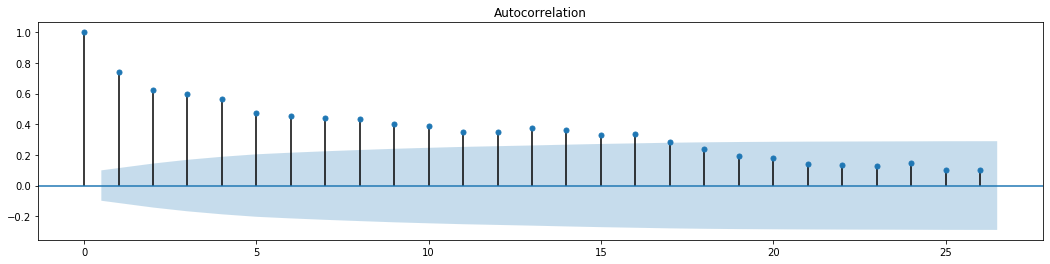

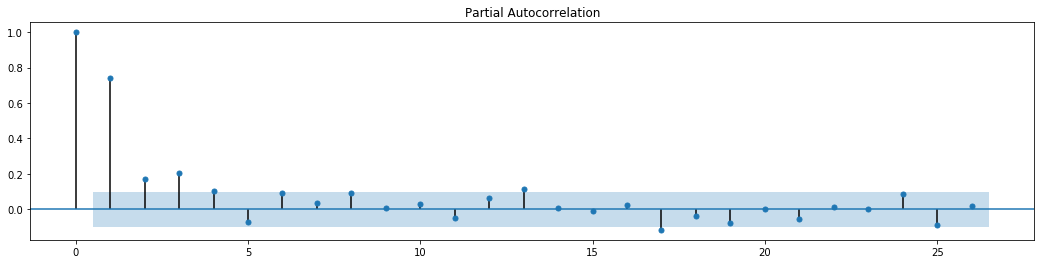

---- Regular regression
Mean squared error: 8.88
Variance score: 0.09


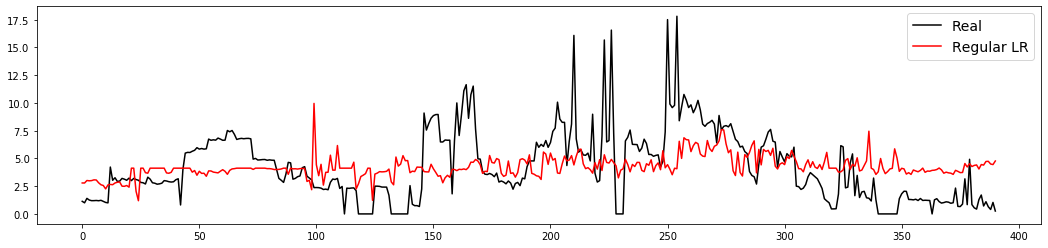

---- AR Error (4)
Mean squared error: 3.1683
Variance score: 0.6757
[ 3.47095023e-03 -2.21467868e-03 -1.20477093e-03 -1.24155030e-03
 -8.74981550e-04 -6.01831038e-05]
Free: 4.332012358510635


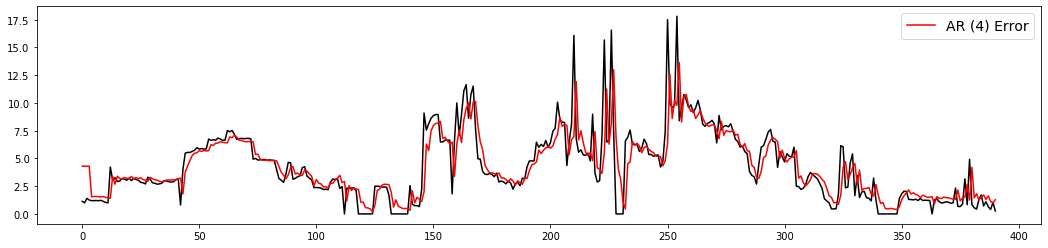

In [8]:

plt.rcParams["figure.figsize"] =(18,4)
Predict_NoL, AR_used, b_free, b_coef = OneCommonLag(0, show_ARMA =True) 

# Regular regression

buf_X = np.array([df.P1, df.P2, df.P3, df.P4, df.P5, df.P6])
LR_Regular = LR().fit(buf_X.transpose(), df.Oil)

print("---- Regular regression")
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(df.Oil, LR_Regular.predict(buf_X.transpose())))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df.Oil, LR_Regular.predict(buf_X.transpose())))
plt.plot(np.array(df.Oil), color = 'black', label = 'Real')
plt.plot(LR_Regular.predict(buf_X.transpose()), color = 'red', label = 'Regular LR')
plt.legend(fontsize = 14)
plt.show()

# Regression AR Error
print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(df.Oil, Predict_NoL.transpose()))
print('Variance score: %.4f' % r2_score(df.Oil, Predict_NoL.transpose()))
print(b_coef)

print('Free:',b_free)
plt.plot(np.array(df.Oil), color = 'black')
plt.plot(Predict_NoL.transpose(), color = 'red', label = 'AR (' + str(AR_used) + ') Error')
plt.legend(fontsize = 14)
plt.show()

In [45]:
import chart_studio.plotly as py
import plotly.graph_objects as go

fig = go.Figure()
# fig.add_trace(go.Scatter(x= df.index , y= df.Oil, mode= 'lines', opacity = 0.9, 
#                  name = 'Дебит нефти', line=dict(color='Black')))


# fig.add_trace(go.Scatter(x= df.index , y= Predict_NoL, mode= 'lines', opacity = 0.9, 
#                  name = 'Regression', line=dict(color='Red')))

fig.update_layout(
    legend_orientation="h",
    width=1600,
    height=900,
    plot_bgcolor='rgba(240, 240, 240, 0.7)')
fig.show()

##### Trying to use model on all period with one lag

In [10]:
# %%time 

# df_res1 = pd.DataFrame()
# row  = 0
# AR_used = [0]
# for ar in AR_used:
#     for l in range(0, 18):
#         df_res1.loc[row, 0] = l
#         Predict, df_res1.loc[row, 1], b_free, b_coef = OneCommonLag(l, p = ar) 
#         df_res1.loc[row, 2] = mean_squared_error(df.Oil[l:], Predict.transpose())
#         df_res1.loc[row, 3] = r2_score(df.Oil[l:], Predict.transpose())
#         row += 1
# df_res1.rename(columns = {0:'Lag',1:'AR order', 2: 'MSE', 3:'VS'}, inplace = True)
# df_res1.to_csv('4.1 Lagged_MSE.csv')

In [11]:
df_res1 = pd.read_csv('4.1 Lagged_MSE.csv', index_col=0)
df_res1.sort_values(by = ['MSE'], ascending = True).head()

,Lag,AR order,MSE,VS
12,12.0,4.0,3.105132,0.682224
14,14.0,4.0,3.136943,0.680515
1,1.0,4.0,3.149544,0.677669
11,11.0,4.0,3.152723,0.677469
13,13.0,4.0,3.153316,0.678143


---- AR Error (4)
Mean squared error: 3.1051
Variance score: 0.6822
Coefficients:  [-0.00375184 -0.00237103  0.00352195  0.00395458 -0.00083806  0.00029681]


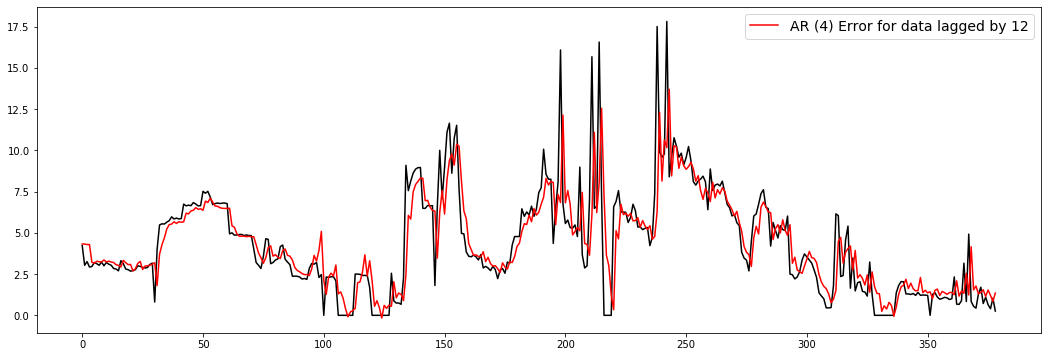

In [12]:
lag= int(df_res1.loc[df_res1['MSE'].idxmin()].Lag)
Predict_ComL, AR_used, b_free, b_coef = OneCommonLag(lag)
ComL_index = df.index[lag:]
plt.rcParams["figure.figsize"] =(18,6)
plt.plot(np.array(df.Oil[lag:]), color = 'black')
print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(df.Oil[lag:], Predict_ComL.transpose()))
print('Variance score: %.4f' % r2_score(df.Oil[lag:], Predict_ComL.transpose()))
print('Coefficients: ', b_coef)
plt.plot(Predict_ComL.transpose(), label = 'AR (' + str(AR_used) + ') Error for data lagged by '+ str(lag), color = 'red')
plt.legend(fontsize = 14)
plt.show()

##### Trying to use model on all period with two different lags

In [13]:
# %%time 
# def TwoCommonLag(l, show_ARMA = False, p=0):
#     max_l = max(l)
#     size = len(df.iloc[:,2:8])
#     P2_lag = np.array(pd.concat([df.iloc[max_l-l[0]:size-l[0],2:8].reset_index(drop=True),
#                                 df.iloc[max_l-l[1]:size-l[1],2:8].reset_index(drop=True)], axis=1))
    
#     if show_ARMA:
#         ARMA_Check(P2_lag, df.Oil[max_l:])
#     return AR_Er(P2_lag, df.Oil[max_l:], p)

# df_res2 = pd.DataFrame()
# row=0
# for l1 in range(1, 18):
#     for l2 in range(l1+1, 18):
#         lag = [l1,l2]
#         max_lag = max(lag)
#         Predict, df_res2.loc[row, 0], b_free, b_coef = TwoCommonLag(lag)
#         df_res2.loc[row, 1] = l1
#         df_res2.loc[row, 2] = l2
#         df_res2.loc[row, 3] = mean_squared_error(df.Oil[max_lag:], Predict.transpose())
#         df_res2.loc[row, 4] = r2_score(df.Oil[max_lag:], Predict.transpose())
#         row+=1
            
# df_res2.rename(columns = {0:'AR', 1: 'L1', 2: 'L2', 3:'MSE', 4: 'VS'}, inplace = True)
# df_res2.to_csv('Two_lagged_MSE.csv')

In [14]:
df_res2 = pd.read_csv('Two_lagged_MSE.csv', index_col=0)
df_res2.sort_values(by = ['MSE'],ascending=True).head()

,AR,L1,L2,MSE,VS
211,4.0,4.0,12.0,3.052109,0.687650
159,4.0,3.0,12.0,3.056769,0.687173
343,4.0,7.0,12.0,3.063429,0.686492
303,4.0,6.0,12.0,3.068110,0.686013
463,4.0,11.0,12.0,3.070491,0.685769


---- AR Error (4)
Mean squared error: 3.0521
Variance score: 0.6877
Coefficients:  [-0.00376893  0.00169503  0.00277238 -0.00145294  0.00264632 -0.00017881
 -0.00423959 -0.00273434  0.00384671  0.0048392  -0.00077907  0.00037149]


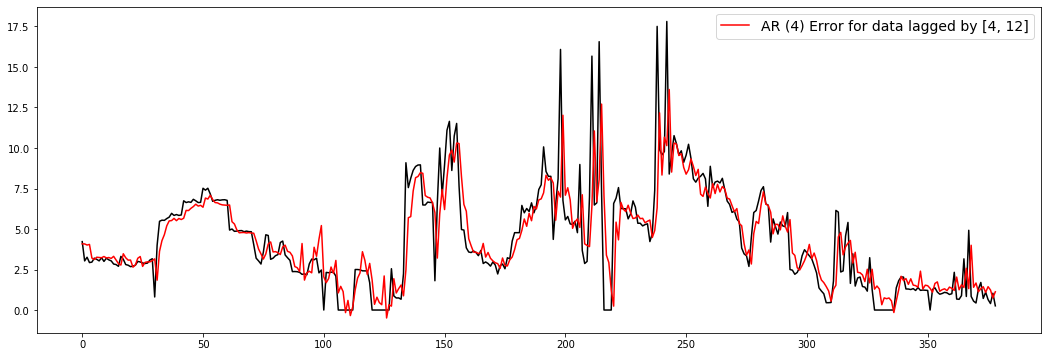

Influence of each pump with each lag
 [-1.24903924  0.56174113  0.91877988 -0.4815123   0.87700325 -0.05925847
 -1.40501786 -0.90617129  1.27481757  1.60373213 -0.25818744  0.12311262]


In [15]:

lag= [int(df_res2.loc[df_res2['MSE'].idxmin()].L1),int(int(df_res2.loc[df_res2['MSE'].idxmin()].L2))]
Predict_ComL2, AR_used, b_free, b_coef = TwoCommonLag(lag)
max_lag = max(lag)
ComL2_index = df.index[max_lag:]
plt.rcParams["figure.figsize"] =(18,6)
plt.plot(np.array(df.Oil[max_lag:]), color = 'black')
print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(df.Oil[max_lag:], Predict_ComL2.transpose()))
print('Variance score: %.4f' % r2_score(df.Oil[max_lag:], Predict_ComL2.transpose()))
print('Coefficients: ', b_coef)
plt.plot(Predict_ComL2.transpose(), label = 'AR (' + str(AR_used) + ') Error for data lagged by '+ str(lag), color = 'red')
plt.legend(fontsize = 14)
plt.show()

print('Influence of each pump with each lag\n', b_coef/(b_coef.sum()))

##### Trying to use model with lags for each pump separatly

In [16]:
# %%time

# df_res3 = pd.DataFrame()
# row = 0

# for i in range(6):
#     for j in range(1, 15):
#         df_res3.loc[row, 0] = i+1
#         df_res3.loc[row, 1] = j
#         Predict, df_res3.loc[row, 2], b_free, b_coef = SeparateLag(i, j)
#         df_res3.loc[row, 3] = mean_squared_error(df.Oil[j:], Predict.transpose())
#         df_res3.loc[row, 4] = r2_score(df.Oil[j:], Predict.transpose())
#         row +=1

# df_res3.rename(columns = {0:'Pump',1:'Lag', 2: 'AR order', 3:'MSE', 4: 'VS'}, inplace = True)
# df_res3.to_csv('Each Pump Separatly.csv')

In [17]:
df_res3 = pd.read_csv('Each Pump Separatly.csv', index_col=0)
df_res3.loc[df_res3.groupby('Pump')['MSE'].idxmin()]

,Pump,Lag,AR order,MSE,VS
11,1.0,12.0,4.0,3.154751,0.677146
25,2.0,12.0,4.0,3.153928,0.677230
39,3.0,12.0,4.0,3.126555,0.680031
53,4.0,12.0,4.0,3.131585,0.679517
69,5.0,14.0,4.0,3.143534,0.679844
81,6.0,12.0,4.0,3.157000,0.676916


##### Trying to make 'Gradient descent'

In [18]:
# %%time

# df_res4 = pd.DataFrame()
# row = 0
# Lag_variants = [
#                 [6,6,6,6,6,6], 
#                 [11,11,11,11,11,11],                   
#                 [3,2,12,11,1,12],
#                ]
# for L in Lag_variants:
#     lag = L.copy()
#     max_lag = max(lag)
#     Predict, AR_used, b_free, b_coef = GradientLag(lag)
#     M_base = mean_squared_error(df.Oil[max_lag:], Predict.transpose())
#     M = M_base                  
#     for i in range( 6):
#         for j in range(i, i+6):
#             k = j%6
#             while(True):  
#                 lag[k] += 1

#                 max_lag = max(lag)
#                 df_res4.loc[row, 0] = lag[0]
#                 df_res4.loc[row, 1] = lag[1]
#                 df_res4.loc[row, 2] = lag[2]
#                 df_res4.loc[row, 3] = lag[3]
#                 df_res4.loc[row, 4] = lag[4]
#                 df_res4.loc[row, 5] = lag[5]
#                 Predict, df_res4.loc[row, 6], b_free, b_coef = GradientLag(lag)
#                 MSE = mean_squared_error(df.Oil[max_lag:], Predict.transpose())
#                 df_res4.loc[row, 7] = MSE
#                 df_res4.loc[row, 8] = r2_score(df.Oil[max_lag:], Predict.transpose())
#                 row +=1
#                 if (M<MSE):
#                     break
#                 M = MSE

#             lag[k] -= 1
#         lag = L.copy()
#         M = M_base

# df_res4.rename(columns = {0:'P1 lag',1:'P2 lag', 2: 'P3 lag', 3:'P4 lag', 4: 'P5 lag', 
#                           5:'P6 lag',6:'AR order', 7: 'MSE', 8: 'VS'}, inplace = True)
# df_res4

Wall time: 1min 52s


,P1 lag,P2 lag,P3 lag,P4 lag,P5 lag,P6 lag,AR order,MSE,VS
0,7.0,6.0,6.0,6.0,6.0,6.0,4.0,3.176765,0.675092
1,8.0,6.0,6.0,6.0,6.0,6.0,4.0,3.223885,0.670283
2,7.0,7.0,6.0,6.0,6.0,6.0,4.0,3.189674,0.673772
3,7.0,6.0,7.0,6.0,6.0,6.0,4.0,3.178698,0.674894
4,7.0,6.0,6.0,7.0,6.0,6.0,4.0,3.183340,0.674419
5,7.0,6.0,6.0,6.0,7.0,6.0,4.0,3.169508,0.675834
6,7.0,6.0,6.0,6.0,8.0,6.0,4.0,3.193513,0.673390
7,7.0,6.0,6.0,6.0,7.0,7.0,4.0,3.178639,0.674900
8,6.0,7.0,6.0,6.0,6.0,6.0,4.0,3.215999,0.671079
9,6.0,6.0,7.0,6.0,6.0,6.0,4.0,3.216198,0.671059


In [19]:

df_res4.sort_values(by = ['MSE'],ascending=True).head()

,P1 lag,P2 lag,P3 lag,P4 lag,P5 lag,P6 lag,AR order,MSE,VS
85,12.0,11.0,12.0,12.0,14.0,11.0,4.0,3.083018,0.686007
137,4.0,2.0,12.0,12.0,4.0,12.0,4.0,3.085873,0.684195
147,4.0,2.0,12.0,12.0,4.0,12.0,4.0,3.085873,0.684195
127,4.0,2.0,12.0,12.0,4.0,12.0,4.0,3.085873,0.684195
124,3.0,2.0,12.0,12.0,4.0,12.0,4.0,3.088033,0.683974


In [20]:
df_res4 = pd.read_csv('Gradient Lag.csv', index_col=0)
df_res4.sort_values(by = ['MSE'],ascending=True).head()

,P1 lag,P2 lag,P3 lag,P4 lag,P5 lag,P6 lag,AR order,MSE
151,12.0,11.0,12.0,12.0,14.0,11.0,4.0,3.083018
117,12.0,11.0,12.0,12.0,12.0,11.0,4.0,3.094665
138,12.0,11.0,12.0,12.0,12.0,11.0,4.0,3.094665
161,12.0,11.0,12.0,12.0,12.0,11.0,4.0,3.094665
118,12.0,11.0,12.0,12.0,13.0,11.0,4.0,3.095738


---- AR Error (4)
Mean squared error: 3.0831
Variance score: 0.6860
Coefficients:  [-0.00518925 -0.00551824  0.00374309  0.00358701  0.00292698]


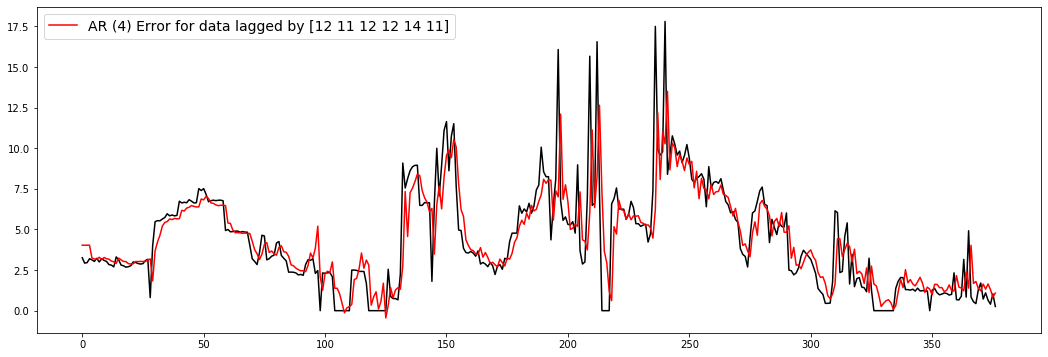

Influence of each pump with each lag
 [11.52118143 12.25160052 -8.31040561 -7.96388632 -6.49849002]
Influence of each pump with each lag (absolute)
 [-0.2475248  -0.26321736  0.17854345  0.17109872  0.13961567]


In [21]:
lag = np.array(df_res4.loc[df_res4['MSE'].idxmin()].iloc[:6], int)

def GradientLag(l, show_ARMA = False, p=0):
    max_l = max(l)
    size = len(df.Oil)
    PG_lag = np.array(pd.concat([df.iloc[(max_l-l[0]):(size-l[0]),2].reset_index(drop=True),
                                 df.iloc[(max_l-l[1]):(size-l[1]),3].reset_index(drop=True),
                                 df.iloc[(max_l-l[2]):(size-l[2]),4].reset_index(drop=True),
                                 df.iloc[(max_l-l[3]):(size-l[3]),5].reset_index(drop=True),
                                 df.iloc[(max_l-l[4]):(size-l[4]),6].reset_index(drop=True),], axis=1))
    if show_ARMA:
        ARMA_Check(PG_lag, df.Oil[max_l:])
    return AR_Er(PG_lag, df.Oil[max_l:], p)

Predict_GL, AR_used, b_free, b_coef = GradientLag(lag)
max_lag = max(lag)
GL_index = np.array(df.index[max_lag:])
plt.rcParams["figure.figsize"] =(18,6)
plt.plot(np.array(df.Oil[max_lag:]), color = 'black')
print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(df.Oil[max_lag:], Predict_GL.transpose()))
print('Variance score: %.4f' % r2_score(df.Oil[max_lag:], Predict_GL.transpose()))
print('Coefficients: ', b_coef)
plt.plot(Predict_GL.transpose(), label = 'AR (' + str(AR_used) + ') Error for data lagged by '+ str(lag), color = 'red')
plt.legend(fontsize = 14)
plt.show()

print('Influence of each pump with each lag\n', b_coef/b_coef.sum())
print('Influence of each pump with each lag (absolute)\n', b_coef/abs(b_coef).sum())

In [22]:
import chart_studio.plotly as py
import plotly.graph_objects as go

Oil = go.Scatter(x= df.index, y= df.Oil, mode= 'lines+markers', opacity = 0.9, 
                 name = 'Oil', marker=dict(color='Black', size=5))

NoL = go.Scatter(x= df.index, y= Predict_NoL, mode= 'lines+markers', opacity = 0.9, 
                 name = 'No lag', marker=dict(color='Green', size=5))

ComL = go.Scatter(x= ComL_index,y=  Predict_ComL, mode= 'lines+markers', opacity = 0.9,
                  name = '1 common lag', marker=dict(color='Orange', size=5))

ComL2 = go.Scatter(x= ComL2_index, y= Predict_ComL2, mode= 'lines+markers', opacity = 0.9,
                   name = '2 common lag', marker=dict(color='Red', size=5))

GL = go.Scatter(x= GL_index, y= Predict_GL, mode= 'lines+markers', opacity = 0.9,
                name = '\'Gradient\' Lags', marker=dict(color='Purple', size=5))

py.iplot([Oil, NoL, ComL, ComL2, GL])

##### Result of model with using proportion instead of Oil

In [23]:
df = pd.read_csv('Clean_data.csv', index_col=0)
df.drop(index = range(215, 274), inplace= True)
df




,Oil,Total,P1,P2,P3,P4,P5,P6,Prop
274,1.133333,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,651.875000,0.666667
275,1.000000,1.548387,0.000000,0.000000,0.000000,0.000000,0.000000,653.333333,0.645833
276,1.400000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,543.120000,0.700000
277,1.250000,1.821429,0.000000,0.000000,0.000000,0.000000,0.000000,556.666667,0.686275
278,1.193548,1.741935,0.000000,0.000000,0.000000,0.000000,0.000000,547.868852,0.685185
279,1.197007,1.735661,0.000000,0.000000,0.000000,0.000000,0.000000,514.916667,0.689655
280,1.211356,1.741325,0.000000,0.000000,0.000000,0.000000,0.000000,520.812500,0.695652
281,1.187713,1.761092,0.000000,0.000000,0.000000,0.000000,0.000000,644.000000,0.674419
282,1.225806,1.774194,0.000000,0.000000,0.000000,0.000000,0.000000,731.000000,0.690909
283,1.129032,1.645161,0.000000,0.000000,0.000000,0.000000,0.000000,763.500000,0.686275


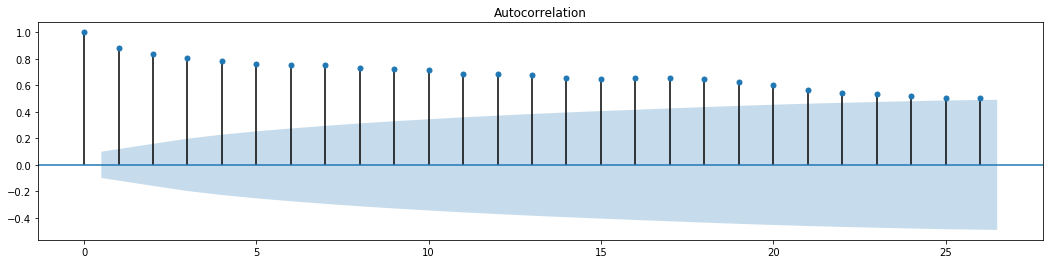

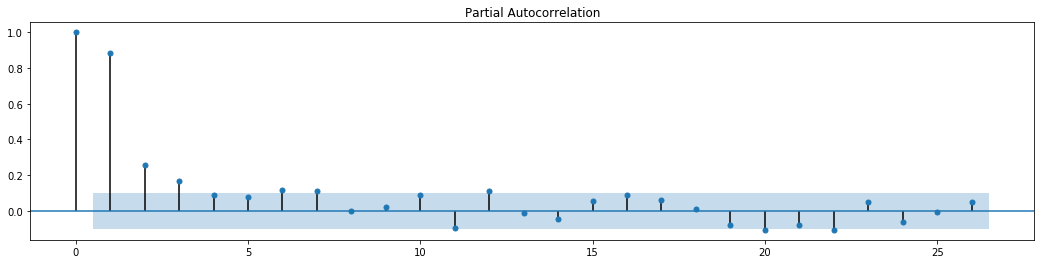

---- Regular regression
Mean squared error: 0.07
Variance score: 0.27


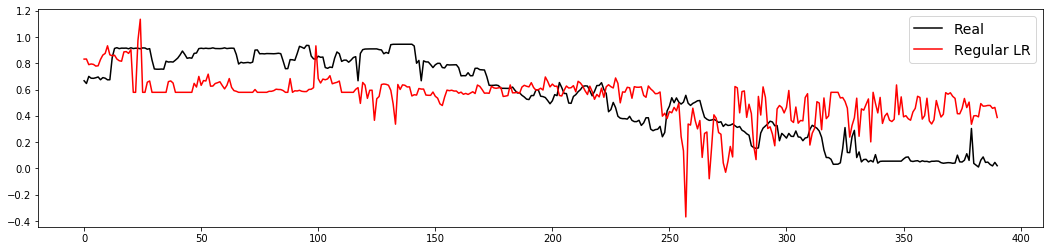

---- AR Error (7)
Mean squared error: 0.0071
Variance score: 0.9260
[ 8.75893555e-05  1.83895280e-04  3.28109536e-05 -6.05043419e-05
  3.74839430e-05  1.33289614e-05]


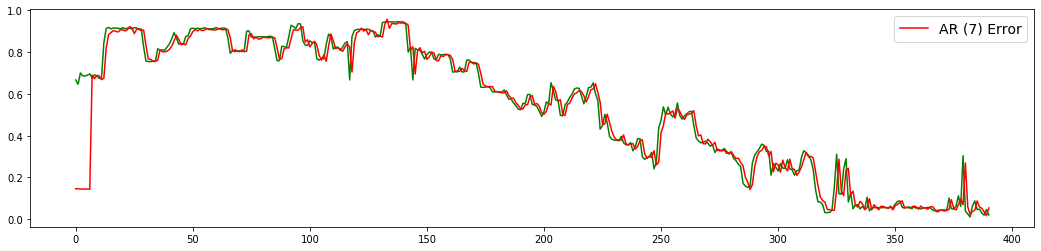

In [24]:
def OneCommonLag_Prop(l, show_ARMA = False, p=0):
    if l == 0:
        P_lag = np.array(df.iloc[:,2:8])
    else:
        P_lag = np.array(df.iloc[:-l,2:8])
    if show_ARMA:
        ARMA_Check(P_lag, df.Prop[l:])
    return AR_Er(P_lag, df.Prop[l:], p)

plt.rcParams["figure.figsize"] =(18,4)
Predict_Prop, AR_used, b_free, b_coef = OneCommonLag_Prop(0, True) 

# Regular regression

buf_X = np.array([df.P1, df.P2, df.P3, df.P4, df.P5, df.P6])
LR_Regular = LR().fit(buf_X.transpose(), df.Prop)

print("---- Regular regression")
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(df.Prop, LR_Regular.predict(buf_X.transpose())))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df.Prop, LR_Regular.predict(buf_X.transpose())))
plt.plot(np.array(df.Prop), color = 'black', label = 'Real')
plt.plot(LR_Regular.predict(buf_X.transpose()), color = 'red', label = 'Regular LR')
plt.legend(fontsize = 14)
plt.show()

# Regression AR Error
print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(df.Prop, Predict_Prop.transpose()))
print('Variance score: %.4f' % r2_score(df.Prop, Predict_Prop.transpose()))
print(b_coef)
plt.plot(np.array(df.Prop), color = 'green')
plt.plot(Predict_Prop.transpose(), color = 'red', label = 'AR (' + str(AR_used) + ') Error')
plt.legend(fontsize = 14)
plt.show()

In [25]:
# %%time

# def GradientLag_Prop(l, show_ARMA = False, p=0):
#     max_l = max(l)
#     size = len(df.Prop)
#     PG_lag = np.array(pd.concat([df.iloc[(max_l-l[0]):(size-l[0]),2].reset_index(drop=True),
#                                  df.iloc[(max_l-l[1]):(size-l[1]),3].reset_index(drop=True),
#                                  df.iloc[(max_l-l[2]):(size-l[2]),4].reset_index(drop=True),
#                                  df.iloc[(max_l-l[3]):(size-l[3]),5].reset_index(drop=True),
#                                  df.iloc[(max_l-l[4]):(size-l[4]),6].reset_index(drop=True),
#                                  df.iloc[(max_l-l[5]):(size-l[5]),7].reset_index(drop=True)], axis=1))
#     if show_ARMA:
#         ARMA_Check(PG_lag, df.Prop[max_l:])
#     return AR_Er(PG_lag, df.Prop[max_l:], p)


# df_res5 = pd.DataFrame()
# row = 0
# Lag_variants = [[0,0,0,0,0,0],
#                 [1,1,1,1,1,1],
#                 [11,11,11,11,11,11],                   
#                 [12,12,12,12,12,12],
#                 [13,13,13,13,13,13],     
#                 [14,14,14,14,14,14],
#                ]
# for L in Lag_variants:
#     lag = L.copy()
#     max_lag = max(lag)
#     Predict, AR_used, b_free, b_coef = GradientLag_Prop(lag)
#     M_base = mean_squared_error(df.Prop[max_lag:], Predict.transpose())
#     M = M_base                  
#     for i in range( 6):
#         for j in range(i, i+6):
#             k = j%6
#             while(True):  
#                 lag[k] += 1

#                 max_lag = max(lag)
#                 df_res5.loc[row, 0] = lag[0]
#                 df_res5.loc[row, 1] = lag[1]
#                 df_res5.loc[row, 2] = lag[2]
#                 df_res5.loc[row, 3] = lag[3]
#                 df_res5.loc[row, 4] = lag[4]
#                 df_res5.loc[row, 5] = lag[5]
#                 Predict, df_res5.loc[row, 6], b_free, b_coef = GradientLag_Prop(lag)
#                 MSE = mean_squared_error(df.Prop[max_lag:], Predict.transpose())
#                 df_res5.loc[row, 7] = MSE
#                 row +=1
#                 if ((M<MSE)|(MSE==0)):
#                     break
#                 M = MSE

#             lag[k] -= 1
#         lag = L.copy()
#         M = M_base

# df_res5.rename(columns = {0:'P1 lag',1:'P2 lag', 2: 'P3 lag', 3:'P4 lag', 4: 'P5 lag', 
#                           5:'P6 lag',6:'AR order', 7: 'MSE'}, inplace = True)
# df_res5.to_csv('Gradient Lag Prop.csv')

In [26]:
df_res5

NameError: name 'df_res5' is not defined

In [ ]:
# df_res5 = pd.read_csv('Gradient Lag Prop.csv', index_col=0)
# df_res5.sort_values(by = ['MSE'],ascending=True).head()

In [ ]:
# lag = np.array(df_res5.loc[df_res5['MSE'].idxmin()].iloc[:6], int)

# Predict_GL_Prop, AR_used, b_free, b_coef = GradientLag_Prop(lag)
# max_lag = max(lag)

# plt.rcParams["figure.figsize"] =(18,6)
# plt.plot(np.array(df.Prop[max_lag:]), color = 'black')
# print("---- AR Error (%.0f)" %(AR_used))
# print("Mean squared error: %.4f" % mean_squared_error(df.Prop[max_lag:], Predict_GL_Prop.transpose()))
# print('Variance score: %.4f' % r2_score(df.Prop[max_lag:], Predict_GL_Prop.transpose()))
# print('Coefficients: ', b_coef)
# plt.plot(Predict_GL_Prop.transpose(), 
#          label = 'AR (' + str(AR_used) + ') Error for data lagged by '+ str(lag), color = 'red')
# plt.legend(fontsize = 14)
# plt.show()

# print('Influence of each pump with each lag\n', b_coef/b_coef.sum())